In [1]:
import pandas as pd
import numpy as np
from Higgs.tools.ExclusionLlh import regularizeExclusionLlh, commonRatePlane
from Higgs.tools.Inspire import getMetadata
import pickle
import json
import os, sys
from collections import OrderedDict

sys.path.insert(0, os.path.dirname(os.path.dirname(os.getcwd())))
import MassResolutions as resolution


# ATLAS 139fb-1 [2002.12223](https://arxiv.org/abs/2002.12223)
First download all the tables from hepdata. It may be useful to store them in a pickle, because the download takes ages.



In [ ]:
baseurl = "https://www.hepdata.net/download/table/ins1782650/"
masses = [200, 250, 300, 350, 400, 500, 600, 700, 800, 1000, 1200, 1500, 2000, 2500]


def getTable(i):
    return pd.read_csv(baseurl + "Table{}/2/csv".format(i), comment="#")


obs = {m: getTable(i) for m, i in zip(masses, range(23, 37))}
exp = {m: getTable(i) for m, i in zip(masses, range(37, 51))}

pickle.dump(obs, open("obs_llh_ATLAS_139.p", "wb"))
pickle.dump(exp, open("exp_llh_ATLAS_139.p", "wb"))


Load the downloaded tables and 
1. rename the columns to our naming conventions
2. convert rates from `fb` to `pb`
3. regularize the observed limit for any mass planes for which vanishing rates are disfavoured at more than approximately 1sigma
4. set the limit metadata
5. use the `commonRatePlane` function to interpolate observed and expected llh profiles onto a common grid
6. write the limit to a file


regularizing for m = 350
regularizing for m = 400
regularizing for m = 500


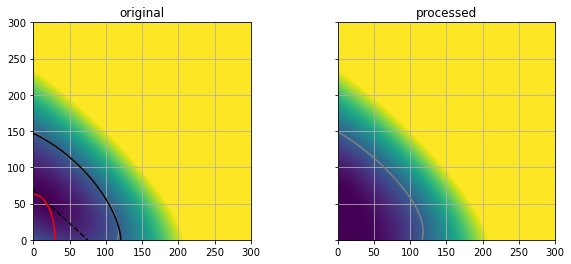

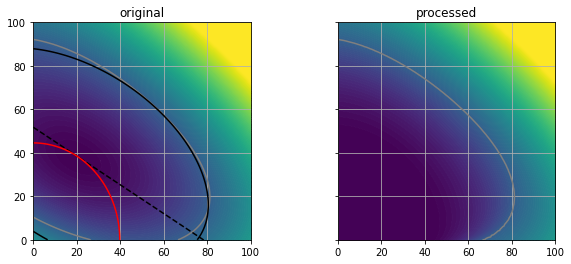

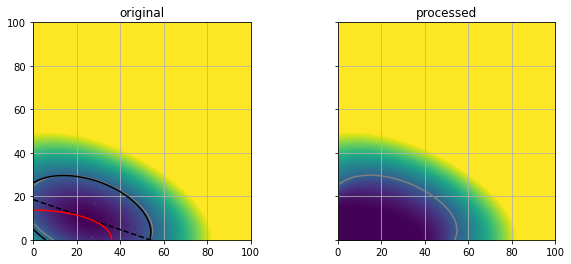

In [2]:
obs = pickle.load(open("obs_llh_ATLAS_139.p", "rb"))
exp = pickle.load(open("exp_llh_ATLAS_139.p", "rb"))

for e in exp.values():
    e.rename(
        columns={
            r"$\sigma(gg\phi)B$ [fb]": "gg",
            r"$\sigma(bb\phi)B$ [fb]": "bb",
            r"$2\Delta(\mathrm{NLL})$": "exp",
        },
        inplace=True,
    )
    e.gg = 1e-3 * e.gg
    e.bb = 1e-3 * e.bb
for m, o in obs.items():
    o.rename(
        columns={
            r"$\sigma(gg\phi)B$ [fb]": "gg",
            r"$\sigma(bb\phi)B$ [fb]": "bb",
            r"$2\Delta(\mathrm{NLL})$": "obs",
        },
        inplace=True,
    )
    if o[(o.gg == 0) & (o.bb == 0)].iloc[0].obs > 2.3:
        print("regularizing for m = {}".format(m))
        regularizeExclusionLlh(o, "gg", "bb")
    o.gg = 1e-3 * o.gg
    o.bb = 1e-3 * o.bb

data = getMetadata("2002.12223")
data["limitClass"] = "LikelihoodLimit"
data["source"] = "Tab. 23-36 (obs) & 37-50 (exp)"
data["process"] = [{"channels": [["ggH", "tautau"]]}, {"channels": [["bbH", "tautau"]]}]
data["analysis"] = OrderedDict()
data["analysis"]["massResolution"] = resolution.tautau["default"]

stackedGrids = []
for m in exp.keys():
    dat = commonRatePlane(obs[m], exp[m], ["gg", "bb"])
    dat["mass"] = m
    stackedGrids.append(dat)

data["analysis"]["stackedLlhGrid"] = stackedGrids
with open("LLH_LHC13_ATLAS_139.json", "w") as f:
    json.dump(data, f)


# CMS 8TeV 19.7fb-1 [CMS-PAS-HIG-14-029](http://cms-results.web.cern.ch/cms-results/public-results/preliminary-results/HIG-14-029/index.html)


regularizing for m = 400
No arxiv eprint found.
Multiple different luminosity values: [19.7, 4.9, 24.6] using 19.7 unless you set it manually


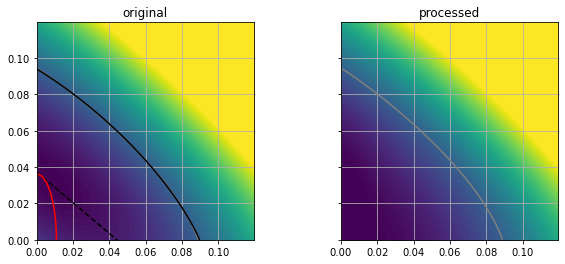

In [3]:
masses = [
    90,
    100,
    120,
    130,
    140,
    160,
    180,
    200,
    250,
    300,
    350,
    400,
    450,
    500,
    600,
    700,
    800,
    900,
    1000,
]

origExp = {
    m: pd.read_table(
        "https://twiki.cern.ch/twiki/pub/CMSPublic/Hig14029Twiki/L_asimov_b_{}.out".format(
            m
        ),
        sep=r"\s+",
        names=["gg", "bb", "exp"],
    )
    for m in masses
}
origObs = {
    m: pd.read_table(
        "https://twiki.cern.ch/twiki/pub/CMSPublic/Hig14029Twiki/L_data_b_{}.out".format(
            m
        ),
        sep=r"\s+",
        names=["gg", "bb", "obs"],
    )
    for m in masses
}


def complete_llh_slice(df, llh, m):
    """
    Some values in these grids are missing and the grids are way larger than
    necessary. So we do some massaging on the data first.
    """
    from collections import Counter
    from scipy.interpolate import griddata

    # decide on the grid to use
    valid_gg = sorted([x for x, c in Counter(df.gg).items() if c >= 195])
    valid_bb = sorted([x for x, c in Counter(df.bb).items() if c >= 195])
    if len(valid_gg) > 100:
        if len(valid_gg) % 2 == 0:
            valid_gg = valid_gg[::2] + [valid_gg[-1]]
        else:
            valid_gg = valid_gg[::2]
    if len(valid_bb) > 100:
        if len(valid_bb) % 2 == 0:
            valid_bb = valid_bb[::2] + [valid_bb[-1]]
        else:
            valid_bb = valid_bb[::2]

    GG, BB = np.meshgrid(valid_gg, valid_bb)

    # factor 2 because CMS gives chisq/2
    data = griddata(df[["gg", "bb"]], df[llh] * 2.0, (GG, BB), method="linear")
    if np.isnan(data[0, 0]):
        data[0, 0] = (data[0, 1] + data[1, 0]) / 2.0
    if np.any(~np.isfinite(data)):
        print("NaN for m = ", m, ":", np.where(~np.isfinite(data)))

    # we would clamp on the lower values anyways, so just set them to 0
    valid_gg[0] = 0.0
    valid_bb[0] = 0.0
    GG, BB = np.meshgrid(valid_gg, valid_bb)
    return pd.DataFrame(
        {
            "gg": GG.flatten(),
            "bb": BB.flatten(),
            llh: data.flatten(),
        }
    )


exp = {m: complete_llh_slice(df, "exp", m) for m, df in origExp.items()}
obs = {m: complete_llh_slice(df, "obs", m) for m, df in origObs.items()}
for m, o in obs.items():
    if o[(o.gg == 0) & (o.bb == 0)].iloc[0].obs > 2.3:
        print("regularizing for m = {}".format(m))
        regularizeExclusionLlh(o, "gg", "bb")

data = getMetadata(1387216)
data["limitClass"] = "LikelihoodLimit"
data["luminosity"] = 24.6
data["reference"] = "CMS-PAS-HIG-14-029"
data["id"] = 14029
data["source"] = "https://twiki.cern.ch/twiki/bin/view/CMSPublic/Hig14029Twiki"
data["process"] = [{"channels": [["ggH", "tautau"]]}, {"channels": [["bbH", "tautau"]]}]
data["analysis"] = OrderedDict()
data["analysis"]["massResolution"] = resolution.tautau["default"]

stackedGrids = []
for m in exp.keys():
    dat = commonRatePlane(obs[m], exp[m], ["gg", "bb"])
    dat["mass"] = m
    stackedGrids.append(dat)


data["analysis"]["stackedLlhGrid"] = stackedGrids
with open("LLH_LHC8_CMS_20.json", "w") as f:
    json.dump(data, f)


# CMS 13TeV 35.9fb-1 [1803.06553](http://arxiv.org/abs/1803.06553)


regularizing for m = 120
regularizing for m = 600
regularizing for m = 700


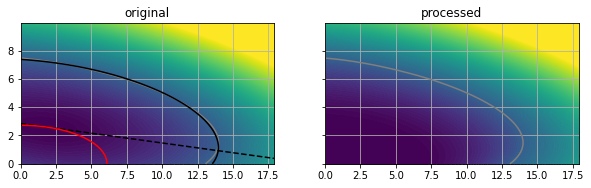

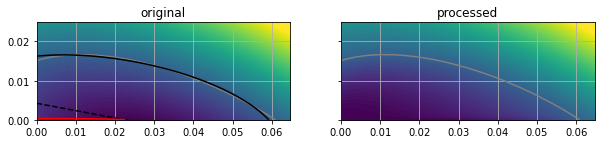

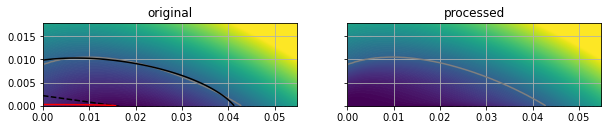

In [8]:
masses = [
    90,
    100,
    110,
    120,
    130,
    140,
    160,
    180,
    200,
    250,
    350,
    400,
    450,
    500,
    600,
    700,
    800,
    900,
    1000,
    1200,
    1400,
    1600,
    1800,
    2000,
    2300,
    2600,
    2900,
    3200,
]

exp = {
    m: pd.read_table(
        "http://cms-results.web.cern.ch/cms-results/public-results/publications/HIG-17-020/2D-likelihood-scans/2D_scan_noSMHinBG_Asimov_{}.txt".format(
            m
        ),
        sep=r"\s+",
        names=["gg", "bb", "exp"],
    )
    for m in masses
}
obs = {
    m: pd.read_table(
        "http://cms-results.web.cern.ch/cms-results/public-results/publications/HIG-17-020/2D-likelihood-scans/2D_scan_noSMHinBG_{}.txt".format(
            m
        ),
        sep=r"\s+",
        names=["gg", "bb", "obs"],
    )
    for m in masses
}

for e in exp.values():
    e.exp = e.exp * 2  # correct for tabulated chi^2/2
    e.sort_values(by=["bb", "gg"], inplace=True)
    e.reset_index(drop=True)
for m, o in obs.items():
    o.obs = o.obs * 2  # correct for tabulated chi^2/2
    o.sort_values(by=["bb", "gg"], inplace=True)
    o.reset_index(drop=True)
    if o[(o.gg == 0) & (o.bb == 0)].iloc[0].obs > 2.3:
        print("regularizing for m = {}".format(m))
        regularizeExclusionLlh(o, "gg", "bb")

data = getMetadata(1663234)
data["limitClass"] = "LikelihoodLimit"
data[
    "source"
] = "https://cms-results.web.cern.ch/cms-results/public-results/publications/HIG-17-020/"
data["process"] = [{"channels": [["ggH", "tautau"]]}, {"channels": [["bbH", "tautau"]]}]
data["analysis"] = OrderedDict()
data["analysis"]["massResolution"] = resolution.tautau["default"]

stackedGrids = []
for m in exp.keys():
    # round to 5 significant digits to keep the file size down
    dat = commonRatePlane(obs[m], exp[m], ["gg", "bb"], floatPrecision=5)
    dat["mass"] = m
    stackedGrids.append(dat)


data["analysis"]["stackedLlhGrid"] = stackedGrids
with open("LLH_LHC13_CMS_36.json", "w") as f:
    json.dump(data, f)
